**Read the processed dataset**

In [3]:
proc_dateset2 = pd.read_csv('Processes-dataset.csv')

proc_dateset2.drop(proc_dateset2.columns[0], axis=1, inplace=True)

proc_dateset2

,review,sentiment
0,one reviewer mention watch oz episode hook rig...,1
1,wonderful little production br br film techniq...,1
2,think wonderful way spend time hot summer week...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1
...,...,...
49571,think movie right good job creative original f...,1
49572,bad plot bad dialogue bad acting idiotic direc...,0
49573,catholic teach parochial elementary school nun...,0
49574,go disagree previous comment side maltin one s...,0


In [49]:
proc_dateset3 = proc_dateset2.iloc[0:15000]
proc_dateset3

,review,sentiment
0,one reviewer mention watch oz episode hook rig...,1
1,wonderful little production br br film techniq...,1
2,think wonderful way spend time hot summer week...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1
...,...,...
14995,never understood appeal garbo always come acro...,0
14996,entirely bad movie plot new house build next d...,0
14997,big md fan call like see film limp along plot ...,0
14998,pure crap probably bad biblical theme film eve...,0


**Split data to train, test and validate**

In [50]:
x, x_test, y, y_test = train_test_split(
    proc_dateset3['review'],
    proc_dateset3['sentiment'],
    test_size=0.2,
    random_state= 42
)

In [51]:
x_train, x_val, y_train, y_val = train_test_split(
    x,
    y,
    test_size=0.33,
    random_state= 42
)

**Get number of rows for each subset**

In [52]:
print(x_train.shape[0])
print(x_val.shape[0])
print(x_test.shape[0])

8040
3960
3000


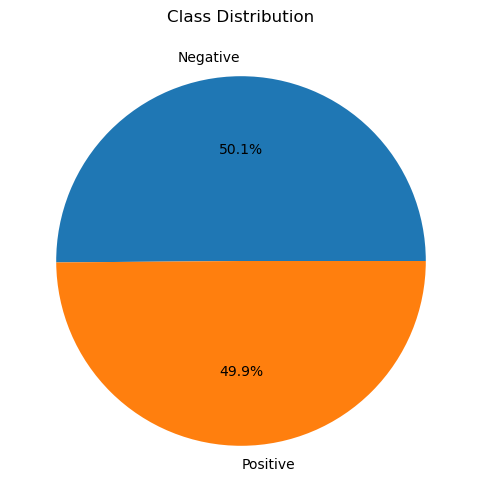

In [53]:
# Map the numerical labels to corresponding categories
classes = {0: 'Negative', 1: 'Positive'}

labels_description = np.array([classes[label] for label in y_train])

# Count the occurrences of each class in the 'labels_description' array
class_counts = np.unique(labels_description, return_counts=True)

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(class_counts[1], labels=class_counts[0], autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

**Encode text using tfidf**

In [54]:
# Create the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the train data
tf_x_train = tfidf_vectorizer.fit_transform(x_train)

In [55]:
print('Number of features is:\n',tfidf_vectorizer.get_feature_names_out().shape)

Number of features is:
 (40574,)


In [56]:
# Transform validation and test data
tf_x_val = tfidf_vectorizer.transform(x_val)
tf_x_test = tfidf_vectorizer.transform(x_test)

## <font color='orange'> ***Train models***</font>

In [62]:
def evaluate_model(clf, x_train, y_train, x_val, y_val):
    clf.fit(x_train, y_train)
    y_pred_train = clf.predict(x_train)
    y_pred_val = clf.predict(x_val)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)

    #print(clf.__class__.__name__)
    #print('Accuracy of training', acc_train)
    #print('Accuracy of validation', acc_val)
    #print('--------------------------')
    return acc_train, acc_val

In [58]:
def plot_conf_matrix(model, X_val, y_val):
    y_pred_val = model.predict(X_val)
    cf = confusion_matrix(y_val, y_pred_val)
    cf_row_sum = cf.sum(axis=1, keepdims=True)
    cf_normalized = cf/cf_row_sum
    sn.heatmap(cf_normalized, annot=True, cmap='Blues')
    plt.show()

## <font color='orange'> ***Model (DT Classifier)***</font>

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

### Initial model

In [60]:
model = DecisionTreeClassifier()
evaluate_model(model, tf_x_train, y_train, tf_x_val, y_val)

DecisionTreeClassifier
Accuracy of training 1.0
Accuracy of validation 0.6946969696969697
--------------------------


(1.0, 0.6946969696969697)

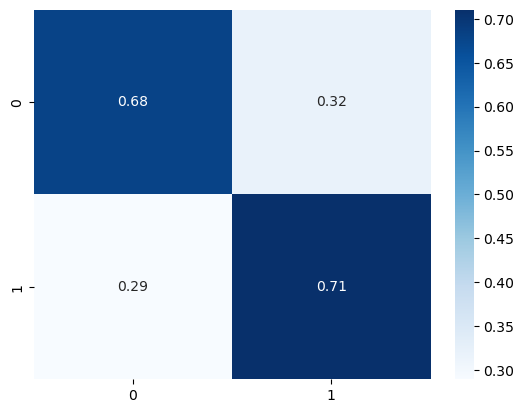

In [61]:
plot_conf_matrix(model, tf_x_val, y_val)

### Hyper-parameter tuning (max_depth)


In [63]:
max_depth_values = list(range(1, 30))
acc_train_values = []
acc_val_values = []

for max_depth in max_depth_values:
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
    acc_train, acc_val = evaluate_model(model, tf_x_train, y_train, tf_x_val, y_val)
    acc_train_values.append(acc_train)
    acc_val_values.append(acc_val)
    
results_max_depth = pd.DataFrame({
    'max_depth': max_depth_values,
    'acc_train': acc_train_values,
    'acc_val': acc_val_values,
})

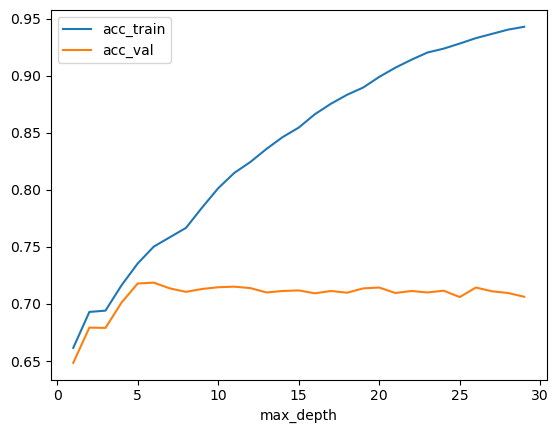

In [64]:
results_max_depth.plot(x='max_depth', y=['acc_train', 'acc_val'])
plt.show()

### Parameter Grid

In [87]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 25, 30],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'random_state':[0, 1, 2, 3],
    'splitter':['best','random']
}

### Instantiate the Model and GridSearchCV

In [88]:
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

### Fit the Grid Search to Data

In [89]:
evaluate_model(grid_search, tf_x_train, y_train, tf_x_val, y_val)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5760 fits failed out of a total of 17280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5760 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\DELL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\DELL\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\DELL\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed

(0.8439054726368159, 0.7252525252525253)

### Access the Results

In [92]:
print("Best Parameters: ", grid_search.best_params_)
print("Best Cross-Validation Score: {:.2f}".format(grid_search.best_score_))

Best Parameters:  {'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 15, 'random_state': 0, 'splitter': 'random'}
Best Cross-Validation Score: 0.73


### Use the Best Model

In [120]:
best_model = DecisionTreeClassifier(max_depth=29, random_state=0, min_samples_split=15, splitter='random',criterion='entropy')
evaluate_model(best_model, tf_x_train, y_train, tf_x_test, y_test)

(0.8865671641791045, 0.7143333333333334)

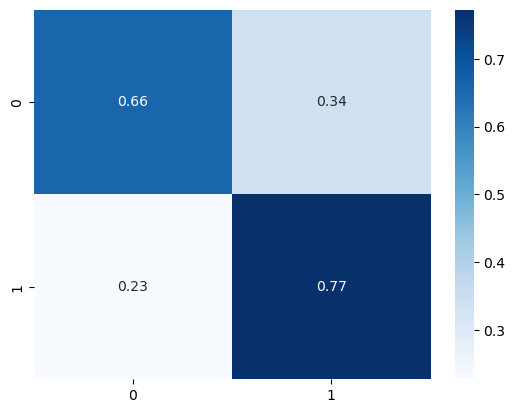

In [121]:
plot_conf_matrix(best_model, tf_x_test, y_test)

In [1]:
'''
GridSearchCV is a method provided by scikit-learn that performs an exhaustive search over a specified parameter grid, evaluating the performance of a machine learning model for each combination of hyperparameters. It is a form of hyperparameter tuning that helps you find the best set of hyperparameters for your model.

Gini Impurity:
Definition: Gini impurity measures the probability of incorrectly classifying a randomly chosen element in the dataset.


Entropy:
Definition: Entropy measures the amount of disorder or uncertainty in a set of data points within a node. It is based on information theory concepts.

Scale: Gini impurity values range from 0 to 1, while entropy values range from 0 to log2(K), where K is the number of classes. Despite the difference in scale, the two criteria often lead to similar results in practice.


 min_samples_split: The minimum number of samples a node must contain to consider splitting. The default value is two. You can use this parameter to regularize your tree. min_samples_leaf: The minimum number of samples needed to be considered a leaf node.

The default value is set to “best”. That is, for each node, the algorithm considers all the features and chooses the best split. If you decide to set the splitter parameter to “random,” then a random subset of features will be considered

The random state ensures that the result that your model will obtain is reproducible .Try it yourself to train decision tree models with different random states and then compare the predictions. After the model has been fit, we can access the following properties of the model: classes_ - a list of class labels

'''

'\nGridSearchCV is a method provided by scikit-learn that performs an exhaustive search over a specified parameter grid, evaluating the performance of a machine learning model for each combination of hyperparameters. It is a form of hyperparameter tuning that helps you find the best set of hyperparameters for your model.\n\nGini Impurity:\nDefinition: Gini impurity measures the probability of incorrectly classifying a randomly chosen element in the dataset.\n\n\nEntropy:\nDefinition: Entropy measures the amount of disorder or uncertainty in a set of data points within a node. It is based on information theory concepts.\n\nScale: Gini impurity values range from 0 to 1, while entropy values range from 0 to log2(K), where K is the number of classes. Despite the difference in scale, the two criteria often lead to similar results in practice.\n\n\n min_samples_split: The minimum number of samples a node must contain to consider splitting. The default value is two. You can use this parameter